In [324]:
import sys, importlib

# matplotlib used plotting. Not required to run the code.
import matplotlib.pyplot as plt
import numpy as np
import joblib

import MCEq
from MCEq.core import MCEqRun
from MCEq.core import config, MCEqRun
import crflux.models as crf

sys.path.append("../../python")

from simhelper import parser, helper_basic, generator
importlib.reload(helper_basic)

<module 'simhelper.helper_basic' from '/home/tomren/geant_projects/mathusla-newsim/tests/cosmic_generator/../../python/simhelper/helper_basic.py'>

In [238]:
# Initalize MCEq by creating the user interface object MCEqRun
mceq = MCEqRun(
    # High-energy hadronic interaction model
    interaction_model='SIBYLL23C',
    # cosmic ray flux at the top of the atmosphere
    primary_model = (crf.HillasGaisser2012, 'H3a'),
    # zenith angle
    theta_deg = 0.
)

# Solve the equation system
mceq.solve()

# Obtain the result
# Multiply fluxes be E**mag to resolve the features of the steep spectrum
mag = 0
neutron_flux = mceq.get_solution('total_n0', mag) + mceq.get_solution('total_nbar0', mag)
proton_flux = mceq.get_solution('total_p+', mag) + mceq.get_solution('total_pbar-', mag)

MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): HillasGaisser2012 H3a


In [239]:
#Dictionary for results
flux_neutron = {}
flux_proton = {}

#Define equidistant grid in cos(theta)
# angles = np.arccos(np.linspace(1,0,41))*180./np.pi
angles = np.linspace(0,1,21)*90

for i, theta in enumerate(angles):
    print(theta, "/" , 90, end="\r")
    mceq.set_theta_deg(theta)
    mceq.solve()
    #_conv means conventional (mostly pions and kaons)
    flux_neutron[theta] = mceq.get_solution('total_n0', mag) + mceq.get_solution('total_nbar0', mag) * 2 * np.pi
    flux_proton[theta] = mceq.get_solution('total_p+', mag) + mceq.get_solution('total_pbar-', mag) * 2 * np.pi

In [330]:
!mkdir -p ../../python/simhelper/data/
joblib.dump({"egrid":mceq.e_grid, "flux_table": flux_neutron}, "../../python/simhelper/data/flux_table_neutron.joblib")
joblib.dump({"egrid":mceq.e_grid, "flux_table": flux_proton}, "../../python/simhelper/data/flux_table_proton.joblib")

['../../python/simhelper/data/flux_table_proton.joblib']

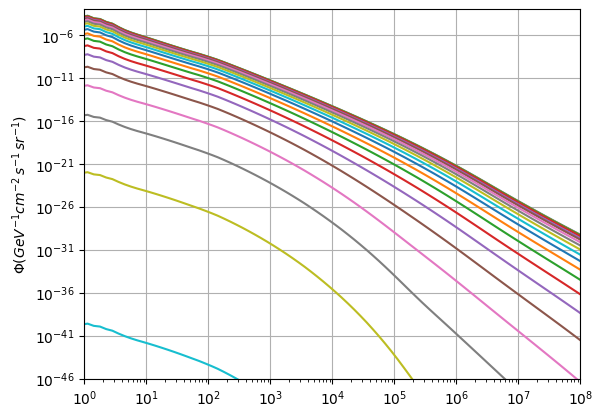

In [265]:
flux = flux_neutron
frac = []
for theta in angles:
    x = mceq.e_grid
    y = flux[theta]
    # if np.cos(theta)>0.5:
    #     continue
    # print(theta, np.cos(theta/180*np.pi))
    # plt.loglog(x, y / (np.cos(theta/180*np.pi)**2), label=f'{theta}')
    plt.loglog(x, y, label=f'{theta}')
    frac.append(flux[theta][11]/flux[0][11])

plt.ylabel(r'$\Phi (GeV^{-1} cm^{-2} \, s^{-1} \, sr^{-1}$)')

plt.xlim(1,1e8)
plt.ylim(1e-46,1e-3)
plt.grid()

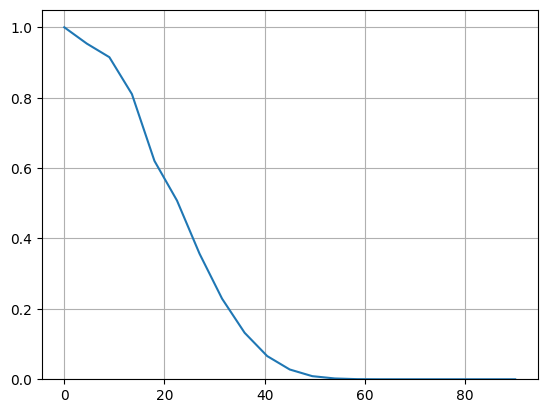

In [207]:
plt.plot(angles, frac)
plt.ylim(0,)
plt.grid()

In [310]:
def cumsum0(y):
    y=np.array(y)
    return np.cumsum(y) - 0.5*y[0] - 0.5*y

def sample_neutron_energy_zenith(flux_dict, energies, num_samples=1, energy_range=None, box_size_meter = [10,10], seed = 1):
    """
    Samples neutron energy and zenith angle from given differential flux distributions.
    
    Parameters:
        flux_dict (dict):
            - Keys are zenith angles (in degrees).
            - Values are numpy arrays of differential flux corresponding to the energy points.
        energies (numpy array):
            - A numpy array of energy values corresponding to the flux arrays.
        num_samples (int):
            - The number of neutron samples to generate.
        energy_range (tuple, optional):
            - A tuple (E_min, E_max) to specify the energy range to sample from.
    
    Returns:
        events: numpy array of shape (num_samples, 2):
            - Each row contains (sampled xyz, sampled uvw, sampled_ekin [GeV])
        flux: total flux [/cm2/s] within the given energy range
    """
    # Setup random generator
    rng = np.random.default_rng(seed = seed)
    
    # Convert angles to a sorted list
    zenith_angles = np.array(sorted(flux_dict.keys()))
    zenith_radians = zenith_angles * np.pi / 180  # Convert to radians

    # Apply energy range filter if specified
    if energy_range is not None:
        E_min, E_max = energy_range
        energy_mask = (energies >= E_min) & (energies <= E_max)
        filtered_energies = energies[energy_mask]
        filtered_flux_dict = {angle: flux[energy_mask] for angle, flux in flux_dict.items()}
    else:
        filtered_energies = energies
        filtered_flux_dict = flux_dict
    
    # Compute total flux at each zenith angle (integrating over filtered energy)
    total_flux_per_angle = np.array([np.trapz(filtered_flux_dict[angle], filtered_energies) for angle in zenith_angles])
    
    # Compute the solid angle element for each zenith angle
    zenith_radians_diff = np.diff(zenith_radians)
    d_omega = 2 * np.pi * (np.cos(zenith_radians[1:] - 0.5*zenith_radians_diff) - np.cos(zenith_radians[1:] + 0.5*zenith_radians_diff))
    d_omega = np.concatenate(([2 * np.pi * (1-np.cos(0.5*zenith_radians_diff[0])) * 2], d_omega))
    
    # Normalize flux by solid angle to get correct probability distribution
    weighted_flux = total_flux_per_angle * d_omega
    weighted_cdf = cumsum0(weighted_flux)
    weighted_cdf /= weighted_cdf[-1]  # Normalize to [0,1]

    total_flux = sum(weighted_flux)/sum(d_omega)
    
    # Sample continuous zenith angles using inverse transform sampling
    sampled_zenith_angles = np.interp(rng.random(num_samples), weighted_cdf, zenith_radians)
    
    sampled_energies = []

    # print(zenith_radians)
    # plt.plot(zenith_radians, weighted_cdf)
    for angle in sampled_zenith_angles:
        # Interpolate flux for continuous angles
        nearest_indices = np.searchsorted(zenith_radians, angle, side='left')
        if nearest_indices == 0:
            interpolated_flux = filtered_flux_dict[zenith_angles[0]]
        elif nearest_indices == len(zenith_angles):
            interpolated_flux = filtered_flux_dict[zenith_angles[-1]]
        else:
            lower_angle, upper_angle = zenith_angles[nearest_indices - 1], zenith_angles[nearest_indices]
            lower_flux, upper_flux = filtered_flux_dict[lower_angle], filtered_flux_dict[upper_angle]
            interpolated_flux = lower_flux + (upper_flux - lower_flux) * (angle - lower_angle * np.pi / 180) / ((upper_angle - lower_angle) * np.pi / 180)
        
        # Normalize the flux to create a probability distribution for energy sampling
        cumulative_distribution = cumsum0(interpolated_flux)
        cumulative_distribution /= cumulative_distribution[-1]  # Normalize to [0,1]
        
        # Sample energy using inverse transform sampling
        random_value = rng.random()
        sampled_energy = np.interp(random_value, cumulative_distribution, filtered_energies)
        sampled_energies.append(sampled_energy)

    sampled_xs = rng.random(num_samples) * box_size_meter[0]
    sampled_ys = rng.random(num_samples) * box_size_meter[1]
    sampled_zs = np.zeros_like(sampled_xs)

    phis = rng.random(num_samples) * 2 * np.pi
    sampled_us = np.sin(sampled_zenith_angles) * np.cos(phis)
    sampled_vs = np.sin(sampled_zenith_angles) * np.sin(phis)
    sampled_ws = np.cos(sampled_zenith_angles)
    
    
    # Return samples as a NumPy array
    return np.column_stack((sampled_xs, sampled_ys ,sampled_zs, sampled_us, sampled_vs, sampled_ws, sampled_energies)), total_flux

def gen_cosmic(filename_output, particle = "n" ,num_samples=1, energy_range=[1e5,1e12], rand_seed=1,  nprint=1000,metadata=None):
    """
    
    Parameters:
        filename_output: str
        particle: str, one of {"n", "p"}
    
    Example:
    """

    # setup output file
    if not os.path.exists(os.path.dirname(filename_output)):
        Path(os.path.dirname(filename_output)).mkdir( parents=True, exist_ok=True )
    tree_writer = iroot.tfile_writer("data", filename_output)
    tree_writer.define_branch("Gen_pdgID", 'vector<double>')    
    tree_writer.define_branch("Gen_x", 'vector<float>')    
    tree_writer.define_branch("Gen_y", 'vector<float>')    
    tree_writer.define_branch("Gen_z", 'vector<float>')    
    tree_writer.define_branch("Gen_t", 'vector<float>')    
    tree_writer.define_branch("Gen_px", 'vector<float>')    
    tree_writer.define_branch("Gen_py", 'vector<float>')    
    tree_writer.define_branch("Gen_pz", 'vector<float>')   

    # Load flux table
    if particle=="n":
        flux_table = joblib.load(os.path.dirname(os.path.realpath(__file__)) + "/data/flux_table_neutron.joblib")
        pdgid = 2112
        mass = 0.939
    elif particle=="p":
        flux_table = joblib.load(os.path.dirname(os.path.realpath(__file__)) + "/data/flux_table_proton.joblib")        
        pdgid = 2212
        mass = 0.938
    else:
        raise ValueError('Set particle to one of {"n", "p"} ')

    samples, total_flux = sample_neutron_energy_zenith(flux_table, energies, num_samples=num_samples, energy_range=num_samples)

    for i in range(num_samples):
        keys = ["Gen_pdgID","Gen_x","Gen_y","Gen_z","Gen_t","Gen_px","Gen_py","Gen_pz"]
        data = {key: [] for key in keys}
        sample = samples[i]
        ek = sample[-1]
        p = np.sqrt(ek**2 + 2 * ek * mass)
        
        data["Gen_pdgID"].append(pdgid)
        data["Gen_x"].append(sample[0] * 1000) # m->mm
        data["Gen_y"].append(sample[1] * 1000) # m->mm
        data["Gen_z"].append(sample[2] * 1000) # m->mm
        data["Gen_t"].append(0)
        data["Gen_px"].append(p*sample[0+3] * 1000) # GeV-> MeV
        data["Gen_py"].append(p*sample[1+3] * 1000) # GeV-> MeV
        data["Gen_pz"].append(p*sample[2+3] * 1000) # GeV-> MeV
        tree_writer.fill(data)
    
    tree_writer.write_and_close()            

In [355]:
samples, total_flux = generator.sample_neutron_energy_zenith(flux_neutron, energies, num_samples=1, energy_range=[1e4,1e12])
total_flux * 6000**2 *3600*24*365*5

8738.882408299465

In [335]:
energies = mceq.e_grid
flux_dict = flux_neutron
samples, total_flux = generator.sample_neutron_energy_zenith(flux_dict, energies, num_samples=100000, energy_range=[1e5,1e12])

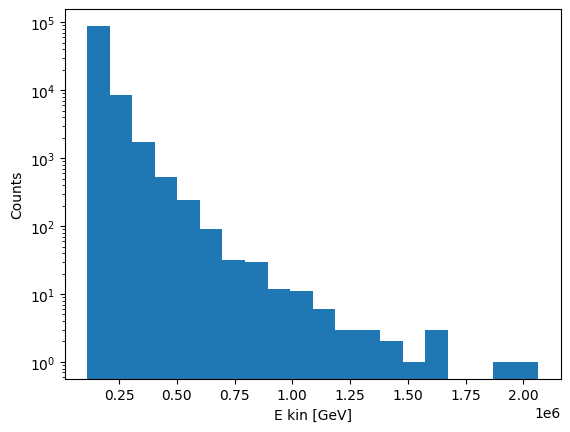

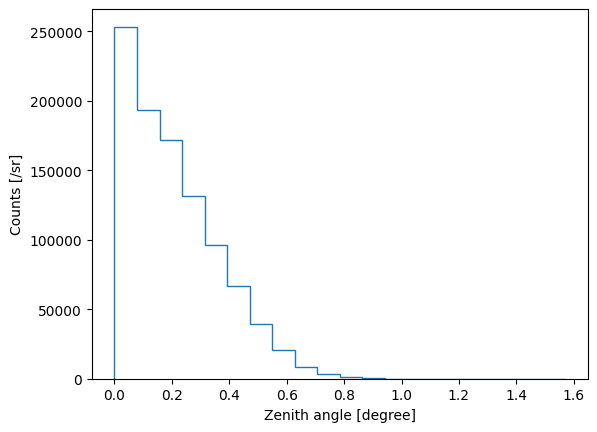

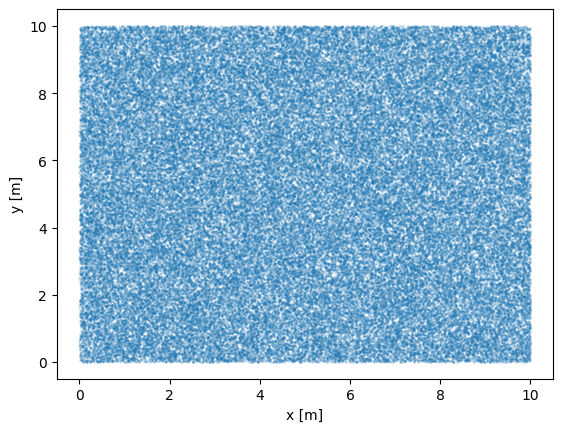

In [337]:
plt.hist(samples[:,-1],bins=20);
plt.yscale("log")
plt.xlabel("E kin [GeV]")
plt.ylabel("Counts")
plt.show()


angles = np.arccos(samples[:,5])
helper_basic.plot_angular_distribution(angles = angles, bins=20, range=(0,np.pi/2))
plt.xlabel("Zenith angle [degree]")
plt.ylabel("Counts [/sr]")
plt.show()

plt.scatter(samples[:,0],samples[:,1], s=1, alpha=0.2)
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.show()

In [349]:
importlib.reload(generator)

<module 'simhelper.generator' from '/home/tomren/geant_projects/mathusla-newsim/tests/cosmic_generator/../../python/simhelper/generator.py'>

In [350]:
total_flux = generator.gen_cosmic("neutron_100TeV.root", particle = "n" ,num_samples=100, energy_range=[1e5,1e12], rand_seed=1,  nprint=100, box_size_meter = [60,60], box_z = 20)

Total flux in selected energy range : 6.355964896315698e-15 /cm2/s


In [ ]:
./simulation -m ../tests/cosmic_generator/run_filereader_cosmic.mac 
./digitizer data/run_0.root 